# Tutorial 1: Polynomial Regression & Bias-Variance Tradeoff

**Author:** S.Jiggins

**Target Audience:** PhD students and early career postdocs  

**Duration:** 20-30 minutes

---

## Overview

This tutorial introduces the fundamentals of PyTorch and machine learning through **polynomial regression**.

### Learning Objectives

By the end of this tutorial, you will:

- Understand PyTorch tensor operations and automatic differentiation
- Learn to create custom model classes using `nn.Module`
- Implement forward passes and parameter optimization for arbitrary polynomial orders
- Grasp the training loop structure and parameter evolution
- Understand feature normalization for numerical stability

---

## Part 1: Setup and Imports

Let's start by importing all necessary libraries and configuring our logging system.

In [1]:
# Standard library imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging

# Tutorial imports
from polynomial_tutorial.Regressor import PolynomialRegressor
from polynomial_tutorial.train import train_model, evaluate_model
from polynomial_tutorial.utils import FeatureNormalizer
from polynomial_tutorial.logger import configure_logging

# Configure logging
configure_logging()
logger = logging.getLogger(__name__)

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ All imports successful!
PyTorch version: 2.10.0+cpu
Device: CPU


---

## Part 2: Configuration

### Experiment Configuration

The bias-variance tradeoff depends on the relationship between:
- **Data polynomial order:** Complexity of the true underlying function
- **Regressor polynomial order:** Complexity of the model we fit

**Three scenarios:**
1. `regressor_order < data_order` → **Underfitting** (high bias)
2. `regressor_order = data_order` → **Good fit** (balanced)
3. `regressor_order > data_order` → **Overfitting** (high variance)

In [2]:
# ============================================================================
# CONFIGURATION: Experiment with these parameters!
# ============================================================================

# TRUE DATA GENERATION
#coeffs_true = [1.0, 0.5, -0.3, 0.1]  # True coefficients [a₀, a₁, a₂, a₃]
coeffs_true = [1.0, 0.5, -0.05]  # True coefficients [a₀, a₁, a₂]
data_poly_order = len(coeffs_true)-1
x_min = 0
x_max = 10

# MODEL CONFIGURATION  
regressor_poly_order = 2  # Order of the MODEL to fit

# TRAINING CONFIGURATION
n_samples = 100
noise_std = 0.5
num_epochs = 10
learning_rate = 0.001

# FEATURE NORMALIZATION (automatic for orders > 2)
# ???? Is this a good idea ????
use_normalization = False
# ???? Or is this better ????
#use_normalization = max(data_poly_order, regressor_poly_order) > 1

normalization_method = 'symmetric'  # Maps to [-1, 1]

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Configuration:")
print(f"  Data polynomial order: {data_poly_order}")
print(f"  Regressor polynomial order: {regressor_poly_order}")
print(f"  Use normalization: {use_normalization}")
print(f"  Samples: {n_samples}, Noise std: {noise_std}")
print(f"  Epochs: {num_epochs}, Learning rate: {learning_rate}")

Configuration:
  Data polynomial order: 2
  Regressor polynomial order: 2
  Use normalization: False
  Samples: 100, Noise std: 0.5
  Epochs: 10, Learning rate: 0.001


---

## Part 3: Data Generation

### Understanding the True Function

We generate data from a polynomial function:

$$y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + ... + \epsilon$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise.

This noise creates the **irreducible error** — the best possible model still has error equal to $\sigma^2$.

In [3]:
def generate_data(coeffs_true, data_poly_order, n_samples=100, 
                  x_min=0, x_max=10, noise_std=0.5):
    """
    Generate synthetic polynomial data with noise.
    
    Args:
        coeffs_true: True polynomial coefficients [a₀, a₁, ..., aₙ]
        data_poly_order: Polynomial order
        n_samples: Number of data points
        x_min, x_max: Range for x values
        noise_std: Standard deviation of Gaussian noise
    
    Returns:
        x_t, y_t: Input and noisy output tensors
    """
    # Validate
    assert len(coeffs_true) == data_poly_order + 1
    
    # Generate x values uniformly
    x = torch.linspace(x_min, x_max, n_samples)
    
    # Compute true y values
    y_true = torch.zeros(n_samples)
    for i, coeff in enumerate(coeffs_true):
        y_true += coeff * (x ** i)
    
    # Add Gaussian noise
    noise = torch.randn(n_samples) * noise_std
    y_noisy = y_true + noise
    
    return x, y_noisy


# Generate data
logger.info("\n[STEP 1] Generating synthetic polynomial data...")
logger.info(f"Data polynomial order: {data_poly_order}")
logger.info(f"True coefficients: {coeffs_true}")

x_t, y_t = generate_data(
    coeffs_true=coeffs_true,
    data_poly_order=data_poly_order,
    n_samples=n_samples,
    x_min=x_min,
    x_max=x_max,
    noise_std=noise_std
)

logger.info(f"Generated {n_samples} data points")
logger.info(f"x range: [{x_t.min():.2f}, {x_t.max():.2f}]")
logger.info(f"y range: [{y_t.min():.2f}, {y_t.max():.2f}]")

2026-02-24 23:32:55,429 | INFO     | __main__:35 | 
[STEP 1] Generating synthetic polynomial data...
2026-02-24 23:32:55,429 | INFO     | __main__:36 | Data polynomial order: 2
2026-02-24 23:32:55,430 | INFO     | __main__:37 | True coefficients: [1.0, 0.5, -0.05]
2026-02-24 23:32:55,431 | INFO     | __main__:48 | Generated 100 data points
2026-02-24 23:32:55,431 | INFO     | __main__:49 | x range: [0.00, 10.00]
2026-02-24 23:32:55,432 | INFO     | __main__:50 | y range: [0.09, 3.30]


### Visualize the Generated Data

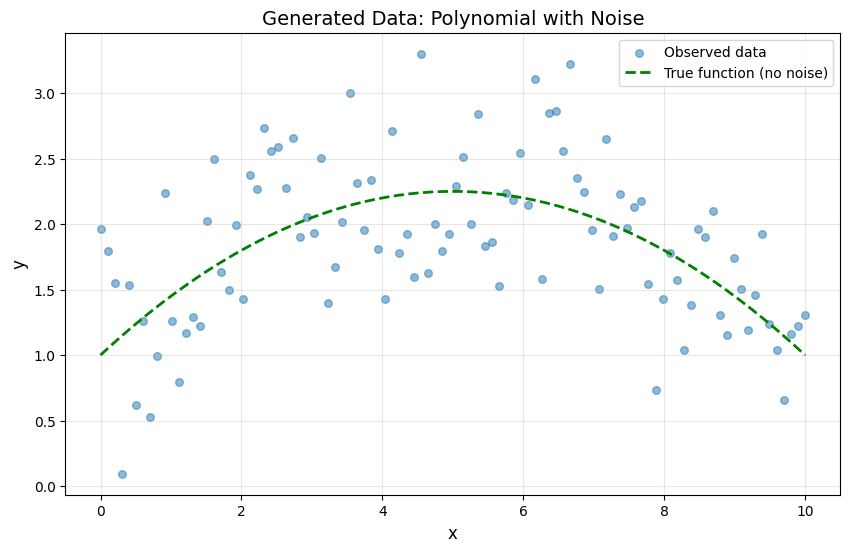


✓ Data generated: 100 points
  True function: y = 1.00x^00.50x^1-0.05x^2
  Noise level (σ): 0.5


In [4]:
# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plot of noisy data
plt.scatter(x_t.numpy(), y_t.numpy(), alpha=0.5, s=30, label='Observed data')

# Plot true function (without noise)
y_true_func = ""
x_dense = torch.linspace(x_min, x_max, 200)
y_true_dense = torch.zeros(200)
for i, coeff in enumerate(coeffs_true):
    y_true_dense += coeff * (x_dense ** i)
    y_true_func += f"{coeff:.2f}x^{i}"

plt.plot(x_dense.numpy(), y_true_dense.numpy(), 'g--', 
         linewidth=2, label='True function (no noise)')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generated Data: Polynomial with Noise', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✓ Data generated: {n_samples} points")
print(f"  True function: y = {y_true_func}")
print(f"  Noise level (σ): {noise_std}")

---

## Part 4: Feature Normalization

### Why Normalization is Critical

When $x \in [0, 10]$ and we compute polynomial features:

| Feature | Range | Magnitude |
|---------|-------|----------|
| $x^0$ | 1 | $10^0$ |
| $x^1$ | [0, 10] | $10^1$ |
| $x^2$ | [0, 100] | $10^2$ ⚠️ |
| $x^3$ | [0, 1000] | $10^3$ ⚠️ |
| $x^4$ | [0, 10,000] | $10^4$ 🚨 |
| $x^5$ | [0, 100,000] | $10^5$ 💥 |

**Problem:** Gradients explode → NaN values → training fails!

Specifically, consider the following example we have used (as default):
\begin{equation}
y = a_{2} x^{2} + a_{1} x + c,
\end{equation}
a simple 2nd order polynomial. If we now want to minimise the difference between the polynomial and our regressor, we minimise the MSE loss:
\begin{equation}
\mathcal{L} = \frac{1}{n}sum_{i} || y_{i} - \hat{y}_{i}||^{2}
\end{equation}
where $y$ is the above true value of the polynomial, and $\hat{y}$ is the assumed regressor with optimisable parameters $\hat{a}_{j}$. As such, when we fit these parameters using the auto-differentiation method installed by default in PyTorch we update each parameter according to:
\begin{equation}
\hat{a}^{e}_{j} \leftarrow \hat{a}^{e-1}_{j} - \eta . \nabla_{\boldsymbol{a}}\mathcal{L},
\end{equation}
where define the gradient as:
\begin{equation}
\nabla_{\boldsymbol{a}} L(\boldsymbol{a})
=
\begin{bmatrix}
\frac{\partial L}{\partial a_0} \\
\frac{\partial L}{\partial a_1} \\
\frac{\partial L}{\partial a_2}
\end{bmatrix}.
\end{equation}
This is where the problem resides. If we consider the gradient with respect to $a_{2}$ term, we get:
\begin{equation}
\frac{\partial\mathcal{L}}{\partial a_{2}} \propto x^{2}.
\end{equation}
Therefore, when $x=10$, the gradient is 100, but for say $a_{1}$ the gradient is 10. This magnitude difference causes stability issues.

**Solution:** Normalize $x$ to $[-1, 1]$ **before** computing powers:
- $(x_{norm})^3$ stays in $[-1, 1]$ ✅
- $(x_{norm})^5$ stays in $[-1, 1]$ ✅

In [5]:
# Apply normalization if needed
normalizer = None

if use_normalization:
    logger.info("\n[STEP 1.5] Applying feature normalization...")
    logger.info(f"⚠️  Polynomial order {max(data_poly_order, regressor_poly_order)} requires normalization!")
    
    normalizer = FeatureNormalizer(method=normalization_method)
    x_t_original = x_t.clone()
    x_t = normalizer.fit_transform(x_t)
    
    logger.info(f"Before: x ∈ [{x_t_original.min():.2f}, {x_t_original.max():.2f}]")
    logger.info(f"After:  x ∈ [{x_t.min():.2f}, {x_t.max():.2f}]")
    logger.info("✓ Features normalized to [-1, 1]")
    
    # Demonstrate the effect
    print("\nNormalization Effect:")
    for order in [1, 2, 3, 4, 5]:
        x_power = x_t ** order
        print(f"  x^{order}: range [{x_power.min():.2f}, {x_power.max():.2f}]")
else:
    logger.info("\n[STEP 1.5] Skipping normalization (order ≤ 2)")

2026-02-24 23:32:55,545 | INFO     | __main__:22 | 
[STEP 1.5] Skipping normalization (order ≤ 2)


---

## Part 5: Model Definition

### The PolynomialRegressor Class

Our model implements:

$$y = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

**Key features:**
- Arbitrary polynomial order
- Learnable coefficients as `nn.Parameter`
- Forward pass computes polynomial features and predictions

In [6]:
# Initialize the model
logger.info("\n[STEP 2] Initializing the polynomial regression model...")
logger.info(f"Regressor polynomial order: {regressor_poly_order}")

model = PolynomialRegressor(order=regressor_poly_order)
logger.info(f"Model initialized with {regressor_poly_order + 1} parameters")

# Analyze bias-variance scenario
if regressor_poly_order < data_poly_order:
    scenario = "UNDERFITTING"
    logger.info("⚠️  UNDERFITTING: Model order < Data order (High Bias)")
elif regressor_poly_order == data_poly_order:
    scenario = "GOOD FIT"
    logger.info("✓ GOOD FIT: Model order = Data order (Balanced)")
else:
    scenario = "OVERFITTING RISK"
    logger.info("⚠️  OVERFITTING RISK: Model order > Data order (High Variance)")

print(f"\nModel Summary:")
print(f"  Architecture: Polynomial regression (order {regressor_poly_order})")
print(f"  Parameters: {regressor_poly_order + 1} coefficients")
print(f"  Scenario: {scenario}")
print(f"\n{model}")

2026-02-24 23:32:55,554 | INFO     | __main__:2 | 
[STEP 2] Initializing the polynomial regression model...
2026-02-24 23:32:55,555 | INFO     | __main__:3 | Regressor polynomial order: 2
2026-02-24 23:32:55,556 | INFO     | __main__:6 | Model initialized with 3 parameters
2026-02-24 23:32:55,557 | INFO     | __main__:14 | ✓ GOOD FIT: Model order = Data order (Balanced)

Model Summary:
  Architecture: Polynomial regression (order 2)
  Parameters: 3 coefficients
  Scenario: GOOD FIT

PolynomialRegressor(order=2, y = -0.0567 - 0.0571x + 0.1598x^2)


---

## Part 6: Training

### The Training Loop

Standard gradient descent optimization:

1. **Forward pass:** Compute predictions
2. **Compute loss:** Mean Squared Error (MSE)
3. **Backward pass:** Compute gradients via autograd
4. **Update:** $\theta \leftarrow \theta - \alpha \nabla L(\theta)$

**Special:** We track parameter evolution to visualize convergence!

In [7]:
# Train the model
logger.info("\n[STEP 3] Training the model...")
logger.info(f"Training on {'NORMALIZED' if use_normalization else 'ORIGINAL'} features")

trained_model, training_history = train_model(
    model=model,
    x_train=x_t,
    y_train=y_t,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    print_every=1,
    verbose=True
)

print(f"\n✓ Training completed!")
print(f"  Final loss: {training_history['loss'][-1]:.6f}")

2026-02-24 23:32:55,567 | INFO     | __main__:2 | 
[STEP 3] Training the model...
2026-02-24 23:32:55,568 | INFO     | __main__:3 | Training on ORIGINAL features
2026-02-24 23:32:56,134 | INFO     | polynomial_tutorial.train:68 | ============================================================
2026-02-24 23:32:56,135 | INFO     | polynomial_tutorial.train:69 | Training Polynomial Regression Model
2026-02-24 23:32:56,135 | INFO     | polynomial_tutorial.train:70 | ============================================================
2026-02-24 23:32:56,136 | INFO     | polynomial_tutorial.train:71 | Model order: 2
2026-02-24 23:32:56,136 | INFO     | polynomial_tutorial.train:72 | Initial parameters: [-0.05671805888414383, -0.05706474184989929, 0.1598038524389267]
2026-02-24 23:32:56,137 | INFO     | polynomial_tutorial.train:73 | Learning rate: 0.001
2026-02-24 23:32:56,137 | INFO     | polynomial_tutorial.train:74 | Number of epochs: 10
2026-02-24 23:32:56,138 | INFO     | polynomial_tutorial.trai

---

## Part 7: Evaluation

### Model Performance

In [8]:
logger.info("\n[STEP 4] Evaluating results...")

fitted_params = trained_model.get_parameters()

if use_normalization:
    logger.info("\n⚠️  Note: Coefficients are for NORMALIZED features")
    logger.info("Cannot directly compare to true coefficients (different scales)")

print(f"\nTrue coefficients (original scale):   {coeffs_true}")
print(f"Fitted coefficients (working scale):  {[f'{p:.4f}' for p in fitted_params]}")

# Compute metrics
metrics = evaluate_model(trained_model, x_t, y_t)
print(f"\nFinal Metrics:")
print(f"  MSE:  {metrics['mse']:.6f}")
print(f"  RMSE: {metrics['rmse']:.6f}")
print(f"\nInterpretation:")
print(f"  Noise level (σ): {noise_std}")
print(f"  RMSE ≈ σ? {abs(metrics['rmse'] - noise_std) < 0.1} (good fit if True)")

2026-02-24 23:32:56,159 | INFO     | __main__:1 | 
[STEP 4] Evaluating results...

True coefficients (original scale):   [1.0, 0.5, -0.05]
Fitted coefficients (working scale):  ['177.1576', '1332.7042', '10703.9570']

Final Metrics:
  MSE:  240017522688.000000
  RMSE: 489915.843750

Interpretation:
  Noise level (σ): 0.5
  RMSE ≈ σ? False (good fit if True)


---

## Part 8: Visualization - Parameter Evolution

### How Parameters Converge During Training

Watching parameters converge helps understand:
- Which coefficients are important (converge to non-zero)
- Which are less important (converge near zero)
- Convergence speed differences


[VISUALIZATION 1] Parameter Evolution


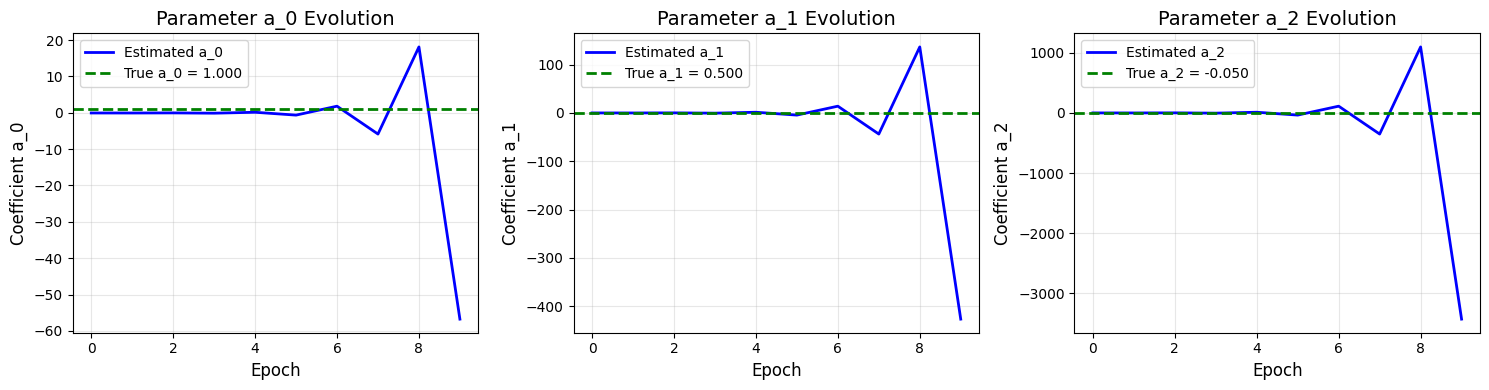

In [9]:
def plot_parameter_evolution(training_history, coeffs_true, model):
    """Visualize parameter convergence."""
    param_history = training_history['params']
    num_epochs = len(param_history)
    
    # Extract parameter array
    param_array = np.array([epoch_params[0].detach().cpu().numpy() 
                            for epoch_params in param_history])
    num_params = param_array.shape[1]
    
    # Compute true coefficients in normalized space (if using normalization)
    coeffs_true_normalized = None
    if use_normalization and normalizer is not None:
        # Generate points in original space
        x_original = torch.linspace(x_min, x_max, 1000)
        y_true = torch.zeros(1000)
        for i, coeff in enumerate(coeffs_true):
            y_true += coeff * (x_original ** i)
        
        # Transform to normalized space
        x_norm = normalizer.transform(x_original)
        
        # Fit polynomial in normalized space to get equivalent coefficients
        # Build design matrix: [1, x_norm, x_norm², ...]
        design_matrix = torch.stack([x_norm ** i for i in range(len(coeffs_true))], dim=1)
        
        # Solve least squares: (X^T X)^{-1} X^T y
        coeffs_true_normalized = torch.linalg.lstsq(design_matrix, y_true).solution.numpy()
        
        print("True coefficients mapping:")
        print("  Original space:", [f"{c:.4f}" for c in coeffs_true])
        print("  Normalized space:", [f"{c:.4f}" for c in coeffs_true_normalized])
    
    # Create subplots
    fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 4))
    if num_params == 1:
        axes = [axes]
    
    epochs = np.arange(num_epochs)
    
    for i in range(num_params):
        ax = axes[i]
        
        # Plot evolution
        ax.plot(epochs, param_array[:, i], 'b-', linewidth=2, 
                label=f'Estimated a_{i}')
        
        # Plot true value
        if i < len(coeffs_true):
            if use_normalization and coeffs_true_normalized is not None:
                # Use normalized-space coefficients
                true_val = coeffs_true_normalized[i]
                ax.axhline(y=true_val, color='g', linestyle='--', 
                          linewidth=2, label=f'True a_{i} (norm.) = {true_val:.3f}')
            else:
                # Use original-space coefficients
                true_val = coeffs_true[i]
                ax.axhline(y=true_val, color='g', linestyle='--', 
                          linewidth=2, label=f'True a_{i} = {true_val:.3f}')
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(f'Coefficient a_{i}', fontsize=12)
        ax.set_title(f'Parameter a_{i} Evolution', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("\n[VISUALIZATION 1] Parameter Evolution")
plot_parameter_evolution(training_history, coeffs_true, trained_model)

---

## Part 9: Visualization - Fitted Curve

### Comparing Model Predictions to True Function


[VISUALIZATION 2] Fitted Curve vs True Function


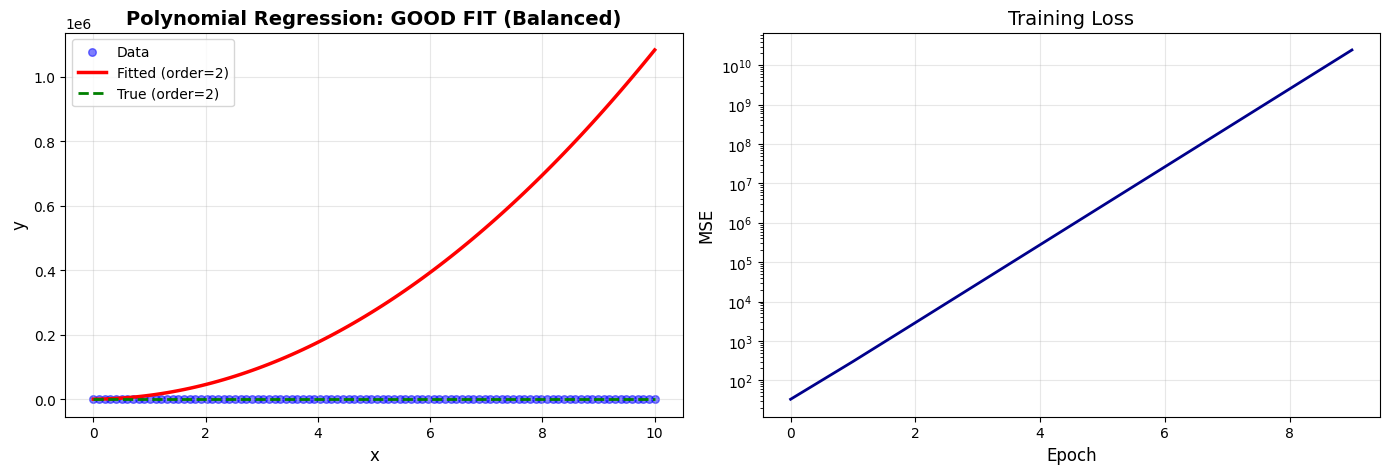

In [10]:
def plot_results(x_t, y_t, model, training_history, coeffs_true, 
                 data_poly_order, normalizer=None):
    """Visualize fitted curve and loss."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Denormalize for display if needed
    if normalizer is not None:
        x_display = normalizer.inverse_transform(x_t).detach().numpy()
        # Dense points for smooth curve
        x_dense_original = torch.linspace(x_display.min(), x_display.max(), 200)
        x_dense_norm = normalizer.transform(x_dense_original)
        
        with torch.no_grad():
            y_pred_dense = model(x_dense_norm).numpy()
        
        # True function
        y_true_dense = torch.zeros_like(x_dense_original)
        for i, coeff in enumerate(coeffs_true):
            y_true_dense += coeff * (x_dense_original ** i)
        
        x_plot = x_dense_original.numpy()
        y_pred_plot = y_pred_dense
        y_true_plot = y_true_dense.numpy()
    else:
        x_display = x_t.detach().numpy()
        with torch.no_grad():
            y_pred_plot = model(x_t).numpy()
        x_plot = x_display
        y_true_plot = torch.zeros_like(x_t)
        for i, coeff in enumerate(coeffs_true):
            y_true_plot += coeff * (x_t ** i)
        y_true_plot = y_true_plot.numpy()
    
    y_np = y_t.detach().numpy()
    
    # Plot 1: Fitted curve
    axes[0].scatter(x_display, y_np, alpha=0.5, s=30, c='blue', label='Data')
    axes[0].plot(x_plot, y_pred_plot, 'r-', linewidth=2.5, 
                 label=f'Fitted (order={model.order})')
    axes[0].plot(x_plot, y_true_plot, 'g--', linewidth=2, 
                 label=f'True (order={data_poly_order})')
    
    # Scenario title
    if model.order < data_poly_order:
        title = "UNDERFITTING (High Bias)"
    elif model.order == data_poly_order:
        title = "GOOD FIT (Balanced)"
    else:
        title = "POTENTIAL OVERFITTING (High Variance)"
    
    axes[0].set_xlabel('x', fontsize=12)
    axes[0].set_ylabel('y', fontsize=12)
    axes[0].set_title(f'Polynomial Regression: {title}', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Loss curve
    loss_history = training_history['loss']
    axes[1].plot(loss_history, linewidth=2, color='darkblue')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MSE', fontsize=12)
    axes[1].set_title('Training Loss', fontsize=14)
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("\n[VISUALIZATION 2] Fitted Curve vs True Function")
plot_results(x_t, y_t, trained_model, training_history, 
             coeffs_true, data_poly_order, normalizer=normalizer)

---

## Part 10: Understanding the Results

### Interpreting the Bias-Variance Scenario

In [11]:
print("="*70)
print(" BIAS-VARIANCE TRADEOFF SUMMARY")
print("="*70)
print(f"\nData Order:       {data_poly_order}")
print(f"Regressor Order:  {regressor_poly_order}")
print(f"Final MSE:        {training_history['loss'][-1]:.6f}")
print(f"RMSE:             {metrics['rmse']:.6f}")
print(f"Noise level (σ):  {noise_std}")

print("\nINTERPRETATION:")

if regressor_poly_order < data_poly_order:
    print("""
🔴 UNDERFITTING (High Bias, Low Variance)
- Model is too simple to capture the true function
- Cannot fit the training data well
- Both training and test error will be high
- Bias dominates the error

Solution: Increase model complexity (higher polynomial order)
""")
elif regressor_poly_order == data_poly_order:
    print("""
🟢 GOOD FIT (Balanced Bias-Variance)
- Model complexity matches data complexity
- Can fit the training data well
- Generalizes well to unseen data
- Optimal tradeoff point

This is the ideal scenario!
""")
else:
    print("""
🟡 OVERFITTING RISK (Low Bias, High Variance)
- Model is too complex for the data
- Fits training data very well (even noise)
- May generalize poorly to new data
- Variance dominates the error

Solution: Reduce model complexity or add regularization
""")

print("="*70)

 BIAS-VARIANCE TRADEOFF SUMMARY

Data Order:       2
Regressor Order:  2
Final MSE:        24583038976.000000
RMSE:             489915.843750
Noise level (σ):  0.5

INTERPRETATION:

🟢 GOOD FIT (Balanced Bias-Variance)
- Model complexity matches data complexity
- Can fit the training data well
- Generalizes well to unseen data
- Optimal tradeoff point

This is the ideal scenario!



---

## Part 11: Experiments to Try

### Experiment 1: Underfitting

Try fitting a **linear model** (order 1) to **cubic data** (order 3):

In [12]:
# Uncomment and run to try underfitting
# data_poly_order = 3
# regressor_poly_order = 1  # Too simple!
# coeffs_true = [1.0, 0.5, -0.3, 0.1]

# Then re-run cells from Part 3 onward

### Experiment 2: Overfitting

Try fitting a **6th order** model to **quadratic data** (order 2):

In [13]:
# Uncomment and run to try overfitting
# data_poly_order = 2
# regressor_poly_order = 6  # Too complex!
# coeffs_true = [1.0, 0.5, -0.3]

# Then re-run cells from Part 3 onward

### Experiment 3: Noise Sensitivity

How does noise affect overfitting?

In [14]:
# Try different noise levels
noise_levels = [0.1, 0.5, 1.0, 2.0]

# Experiment: For each noise level, train overfitted model
# Question: How does noise affect the bias-variance tradeoff?

---

## Part 12: Key Takeaways

### What You've Learned

1. **Bias-Variance Tradeoff:**
   - Model complexity must match data complexity
   - Too simple → high bias (underfitting)
   - Too complex → high variance (overfitting)
   - Just right → balanced (good generalization)

2. **Feature Normalization:**
   - Critical for polynomial orders > 2
   - Prevents numerical instability (NaN values)
   - Normalize **before** computing polynomial features
   - Denormalize for interpretable plots

3. **PyTorch Fundamentals:**
   - Creating custom `nn.Module` classes
   - Training loops with autograd
   - Parameter tracking and visualization
   - Professional logging practices

4. **The Goal is NOT Minimum Training Loss!**
   - Lowest training loss can indicate overfitting
   - Goal: Build models that **generalize to new data**
   - RMSE ≈ noise level σ indicates good fit

### Next Steps

- Try different polynomial orders
- Experiment with noise levels
- Implement cross-validation for model selection
- Add L2 regularization (Ridge regression)
- Move to Tutorial 2: Neural Networks

---
## Part 13: From Regression to Classification

### Same Features, Different Task

Your challenge will now be to train using the **same polynomial features**, a classifier!

**Key Idea:**
- Regression: $y = a_0 + a_1 x + a_2 x^2 + \cdots$
- Classification: $p(c=1|x) = \sigma(a_0 + a_1 x + a_2 x^2 + \cdots)$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

### What Changes?

| Aspect | Regression | Classification |
|--------|-----------|---------------|
| Loss | MSE | Binary Cross-Entropy |
| Output | Real number | Probability [0, 1] |
| Goal | Predict y | Predict class label |

### Constructing data
The data at present is generated by a polynomial:
$y = a_0 + a_1 x + a_2 x^2 + \cdots$

To train a classifier we now need to generate some labels, since a classification problem needs $y \in [0,1]$. Therfore we construct using the polynomial data that is class 0 or 1, based on whether it is:
\begin{equation}
y = 
\begin{cases}
1 \; \textrm{if} \; x>0.5 \\
0 \; \textrm{if} \; x\leq0.5 \\
\end{cases}
\end{equation}



In [22]:
print("="*70)
print(" PART 13: CLASSIFICATION WITH POLYNOMIAL FEATURES")
print("="*70)

logger.info("\n[CLASSIFICATION] Creating binary labels...")

# ===========================================================================
# Create classification labels based on x position
# ===========================================================================

# IMPORTANT: Use the SAME normalized features from regression
# x_t is already normalized if use_normalization=True

with torch.no_grad():
    # Get x in original space for interpretability
    if use_normalization and normalizer is not None:
        x_original = normalizer.inverse_transform(x_t)
    else:
        x_original = x_t
    
    # Create labels: separate left half from right half
    # This creates a simple, learnable decision boundary
    x_midpoint = (x_original.max() + x_original.min()) / 2
    c = (x_original > x_midpoint).float()

logger.info(f"Decision boundary: x = {x_midpoint:.2f}")
logger.info(f"Class distribution: {c.sum().item():.0f} in class 1, {(len(c) - c.sum()).item():.0f} in class 0")

print("\n Classification Task Created:")
print(f"  Decision boundary: x = {x_midpoint:.2f}")
print(f"  Class 1 (right): {c.sum().item():.0f} points")
print(f"  Class 0 (left):  {(len(c) - c.sum()).item():.0f} points")
print(f"  Using same {'NORMALIZED' if use_normalization else 'ORIGINAL'} features as regression")

 PART 13: CLASSIFICATION WITH POLYNOMIAL FEATURES
2026-02-24 23:38:58,743 | INFO     | __main__:5 | 
[CLASSIFICATION] Creating binary labels...
2026-02-24 23:38:58,746 | INFO     | __main__:26 | Decision boundary: x = 5.00
2026-02-24 23:38:58,748 | INFO     | __main__:27 | Class distribution: 50 in class 1, 50 in class 0

 Classification Task Created:
  Decision boundary: x = 5.00
  Class 1 (right): 50 points
  Class 0 (left):  50 points
  Using same ORIGINAL features as regression



[VISUALIZATION] Labeled Data


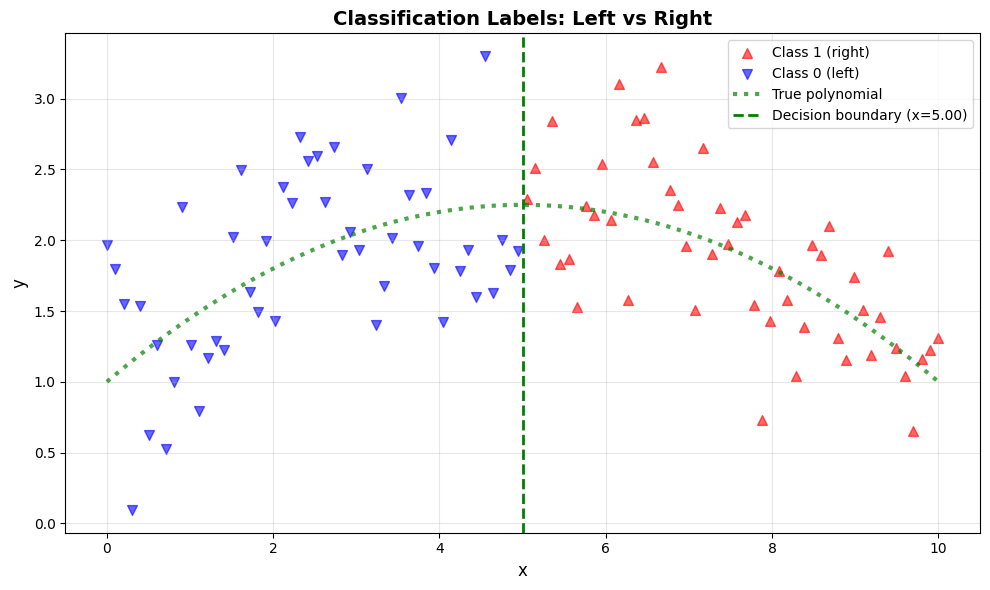


 Data is labeled and ready for classification training!


In [19]:
print("\n[VISUALIZATION] Labeled Data")

# Prepare data for plotting
if use_normalization and normalizer is not None:
    x_display = normalizer.inverse_transform(x_t).detach().numpy()
else:
    x_display = x_t.detach().numpy()

y_np = y_t.detach().numpy()
c_np = c.detach().numpy()

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot data colored by class
ax.scatter(x_display[c_np == 1], y_np[c_np == 1], 
           c='red', alpha=0.6, s=50, label='Class 1 (right)', marker='^')
ax.scatter(x_display[c_np == 0], y_np[c_np == 0], 
           c='blue', alpha=0.6, s=50, label='Class 0 (left)', marker='v')

# Plot true polynomial curve
x_dense = np.linspace(x_display.min(), x_display.max(), 200)
y_true_dense = sum(coeffs_true[i] * (x_dense ** i) for i in range(len(coeffs_true)))
ax.plot(x_dense, y_true_dense, 'g:', linewidth=3, label='True polynomial', alpha=0.7)

# Plot decision boundary (vertical line at midpoint)
ax.axvline(x=x_midpoint.item(), color='green', linestyle='--', 
           linewidth=2, label=f'Decision boundary (x={x_midpoint:.2f})')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Classification Labels: Left vs Right', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Data is labeled and ready for classification training!")

### The Logistic Polynomial Model Problem

Your challenge is to train now a classifier that predicts the probability of being in Class 1:

$$p(c=1|x) = \sigma(a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n)$$

**Key points:**
- Same polynomial features as regression
- Sigmoid $\sigma(z) = \frac{1}{1+e^{-z}}$ maps to probabilities
- Decision boundary: where $p(c=1) = 0.5$ (i.e., where logits = 0)

Good luck !!!

---

## Congratulations!

You've completed Tutorial 1 and learned:
- ✅ Polynomial regression with PyTorch
- ✅ Feature normalization for numerical stability
- ✅ Professional ML coding practices

**Ready for more?** Proceed to Tutorial 2: Perceptron to Deep Neural Networks!